In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',50)
print('numpy version: {} \t pandas version: {}'.format(np.__version__, pd.__version__))
print('lightgbm version: {} \t sklearn version: {}'.format(lightgbm.__version__, sklearn.__version__))

# output: numpy version: 1.17.2 	 pandas version: 0.25.1
# lightgbm version: 2.3.1 	 sklearn version: 0.21.3

numpy version: 1.17.2 	 pandas version: 0.25.1
lightgbm version: 2.3.1 	 sklearn version: 0.21.3


In [2]:
# load data and correct some dtypes of IDs
recipe = pd.read_csv('recipeData.csv', index_col='BeerID', 
                     dtype={'UserId':'object','StyleID':'object'}, 
                     encoding='latin1')

## First Look

### Have a glance

In [3]:
recipe.head(3)

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
BeerID,,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN


In [4]:
recipe.shape

(73861, 22)

### Data Quality

#### Check the missing value property

In [5]:
def missing_property(data):
    """
    To show the property of missing values.
    """
    total = data.isnull().count()
    missing = data.isnull().sum()
    existing = total - missing
    missing_pct = missing / total * 100
    existing_pct = existing / total * 100
    col_type = data.dtypes
    summary = pd.concat([total, existing, missing, 
                         missing_pct, existing_pct, col_type], axis=1)
    summary.columns = ['total', 'existing', 'missing', 'missing_pct', 
                       'existing_pct', 'col_type']
    summary = summary.sort_values('missing_pct', ascending=True).reset_index()
    return summary

In [6]:
missing_property(recipe)

,index,total,existing,missing,missing_pct,existing_pct,col_type
0,BoilSize,73861,73861,0,0.000000,100.000000,float64
1,URL,73861,73861,0,0.000000,100.000000,object
2,BrewMethod,73861,73861,0,0.000000,100.000000,object
3,StyleID,73861,73861,0,0.000000,100.000000,object
4,Size(L),73861,73861,0,0.000000,100.000000,float64
5,OG,73861,73861,0,0.000000,100.000000,float64
6,FG,73861,73861,0,0.000000,100.000000,float64
7,ABV,73861,73861,0,0.000000,100.000000,float64
8,IBU,73861,73861,0,0.000000,100.000000,float64
9,Color,73861,73861,0,0.000000,100.000000,float64


In [7]:
# Let's remove records withount Style
data = recipe[recipe['Style'].notnull()].copy()

In [8]:
col_too_many_missing = ['MashThickness', 'PitchRate','PrimingMethod','PrimingAmount']
# These columns have too many missing values, much more then 25%, which means we shouldn't use them in our modelling. 
# but still, it provides us useful information, 
# so I will tranfer them into binary feature representing if it's missing or not.
for _col in col_too_many_missing:
    data.loc[:,'valid_'+_col] = data[_col].notnull()
    data.drop(_col, axis=1, inplace = True)

In [9]:
cat_features = []
num_features = []
for col in data.columns:
    if data[col].dtype =='object':
        if col not in ['Style', 'StyleID']:
            cat_features.append(col)
    else:
        num_features.append(col)

In [10]:
# to confirm if Style and StyleID is 1-to-1 mapping
style_dist = data.groupby(['Style', 'StyleID']).size().reset_index().rename(columns={0:'count'})
assert style_dist.shape[0] == data.Style.nunique() == data.StyleID.nunique(), \
            'Style and StyleID is not 1-to-1 mapping!!'
style_dist.sort_values(by='count', ascending=False, inplace=True)
# yes, it's 1-to-1, so we can set StyleID as our target instead of Style

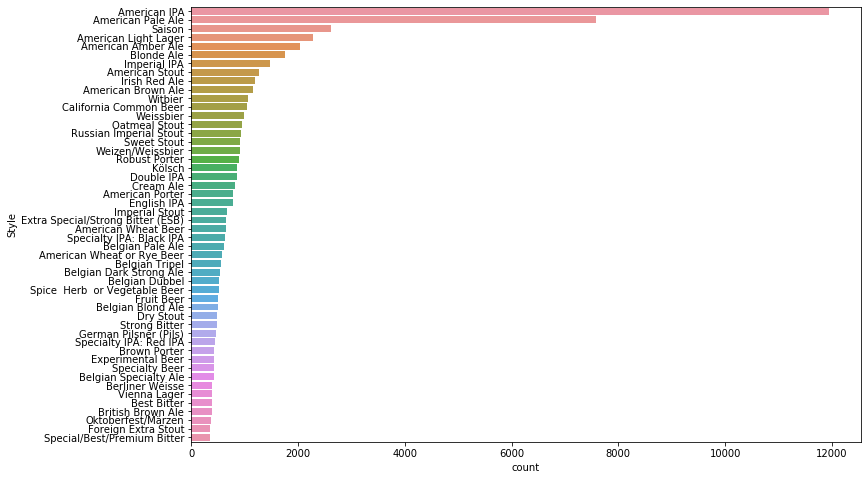

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x = 'count', y = 'Style', data = style_dist[:50])

In [12]:
style_dist.tail(20)

,Style,StyleID,count
131,Sahti,133,22
74,Fruit Cider,76,22
61,Eisbock,62,21
2,Alternative Sugar Beer,3,21
78,German Leichtbier,79,20
93,Kellerbier: Amber Kellerbier,95,18
45,Cyser (Apple Melomel),46,17
94,Kellerbier: Pale Kellerbier,96,17
115,Open Category Mead,117,17
121,Piwo Grodziskie,123,15


### Feature Analysis

#### numeric features

In [13]:
print(num_features)

['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'PrimaryTemp', 'valid_MashThickness', 'valid_PitchRate', 'valid_PrimingMethod', 'valid_PrimingAmount']


In [14]:
data[num_features].describe()

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,PrimaryTemp
count,73265.000000,73265.000000,73265.000000,73265.000000,73265.000000,73265.000000,73265.000000,73265.000000,70517.000000,73265.000000,50969.000000
mean,43.993447,1.406331,1.075666,6.138439,44.380476,13.403860,49.800072,65.096922,1.352646,66.335034,19.177332
std,180.515312,2.198052,0.425388,1.874083,41.606932,11.935452,193.310638,15.011683,1.926144,14.095789,4.217123
min,1.000000,1.000000,-0.003000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-17.780000
25%,18.930000,1.051000,1.011000,5.080000,23.490000,5.170000,20.820000,60.000000,1.040000,65.000000,18.000000
50%,20.820000,1.058000,1.013000,5.790000,35.870000,8.440000,27.440000,60.000000,1.047000,70.000000,20.000000
75%,23.660000,1.069000,1.017000,6.830000,56.490000,16.780000,30.000000,60.000000,1.060000,75.000000,20.000000
max,9200.000000,34.034500,10.341400,54.720000,3409.300000,186.000000,9700.000000,240.000000,52.600000,100.000000,114.000000


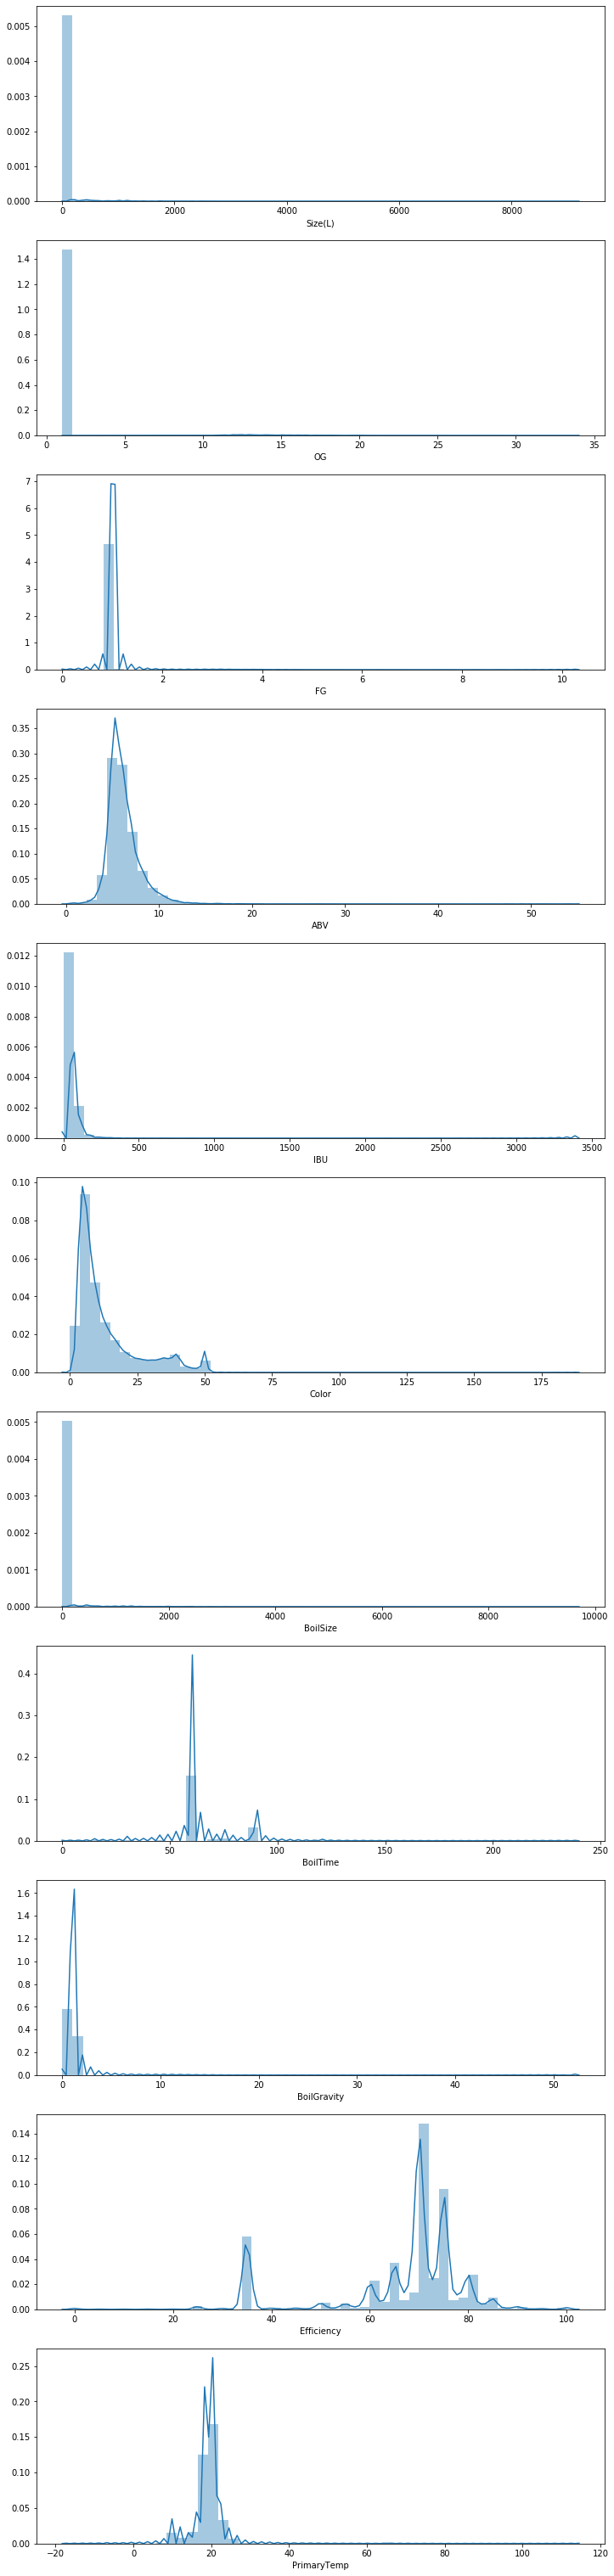

In [15]:
# check the distribution
to_plot_cols = [c for c in num_features if 'valid_' not in c]
f, ax = plt.subplots(len(to_plot_cols),1, sharex='row',figsize=(12,5*len(to_plot_cols)))
for x in range(len(to_plot_cols)):
    sns.distplot(data[data[to_plot_cols[x]].notnull()][to_plot_cols[x]], ax=ax[x])

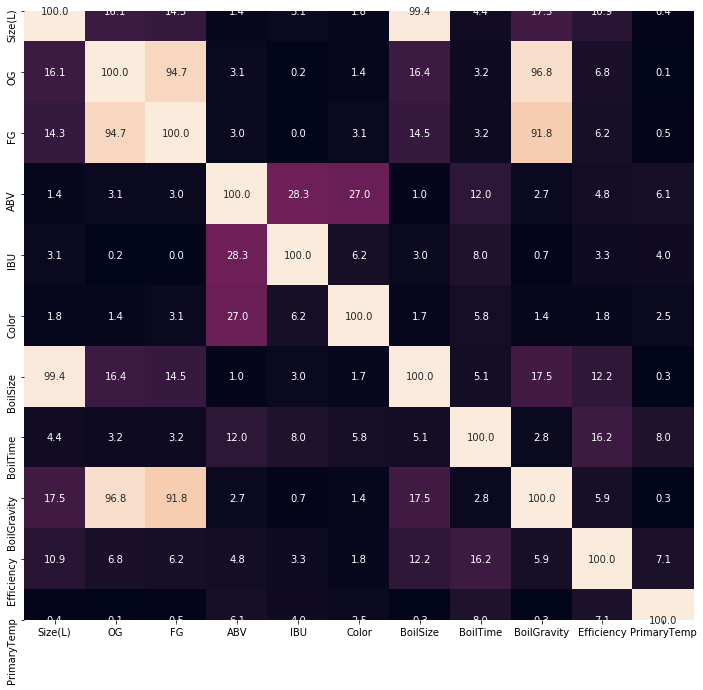

In [16]:
# check the corrlation
corrmat = data[to_plot_cols].corr(method='pearson',min_periods=200)
corrmat = np.abs(corrmat)
corrmat = corrmat*100
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, cbar=False, annot=True, square=True, fmt='.1f', 
            annot_kws={'size': 120//corrmat.shape[0]})
ax.tick_params(axis="x", labelsize=120//corrmat.shape[0])
ax.tick_params(axis="y", labelsize=120//corrmat.shape[0])

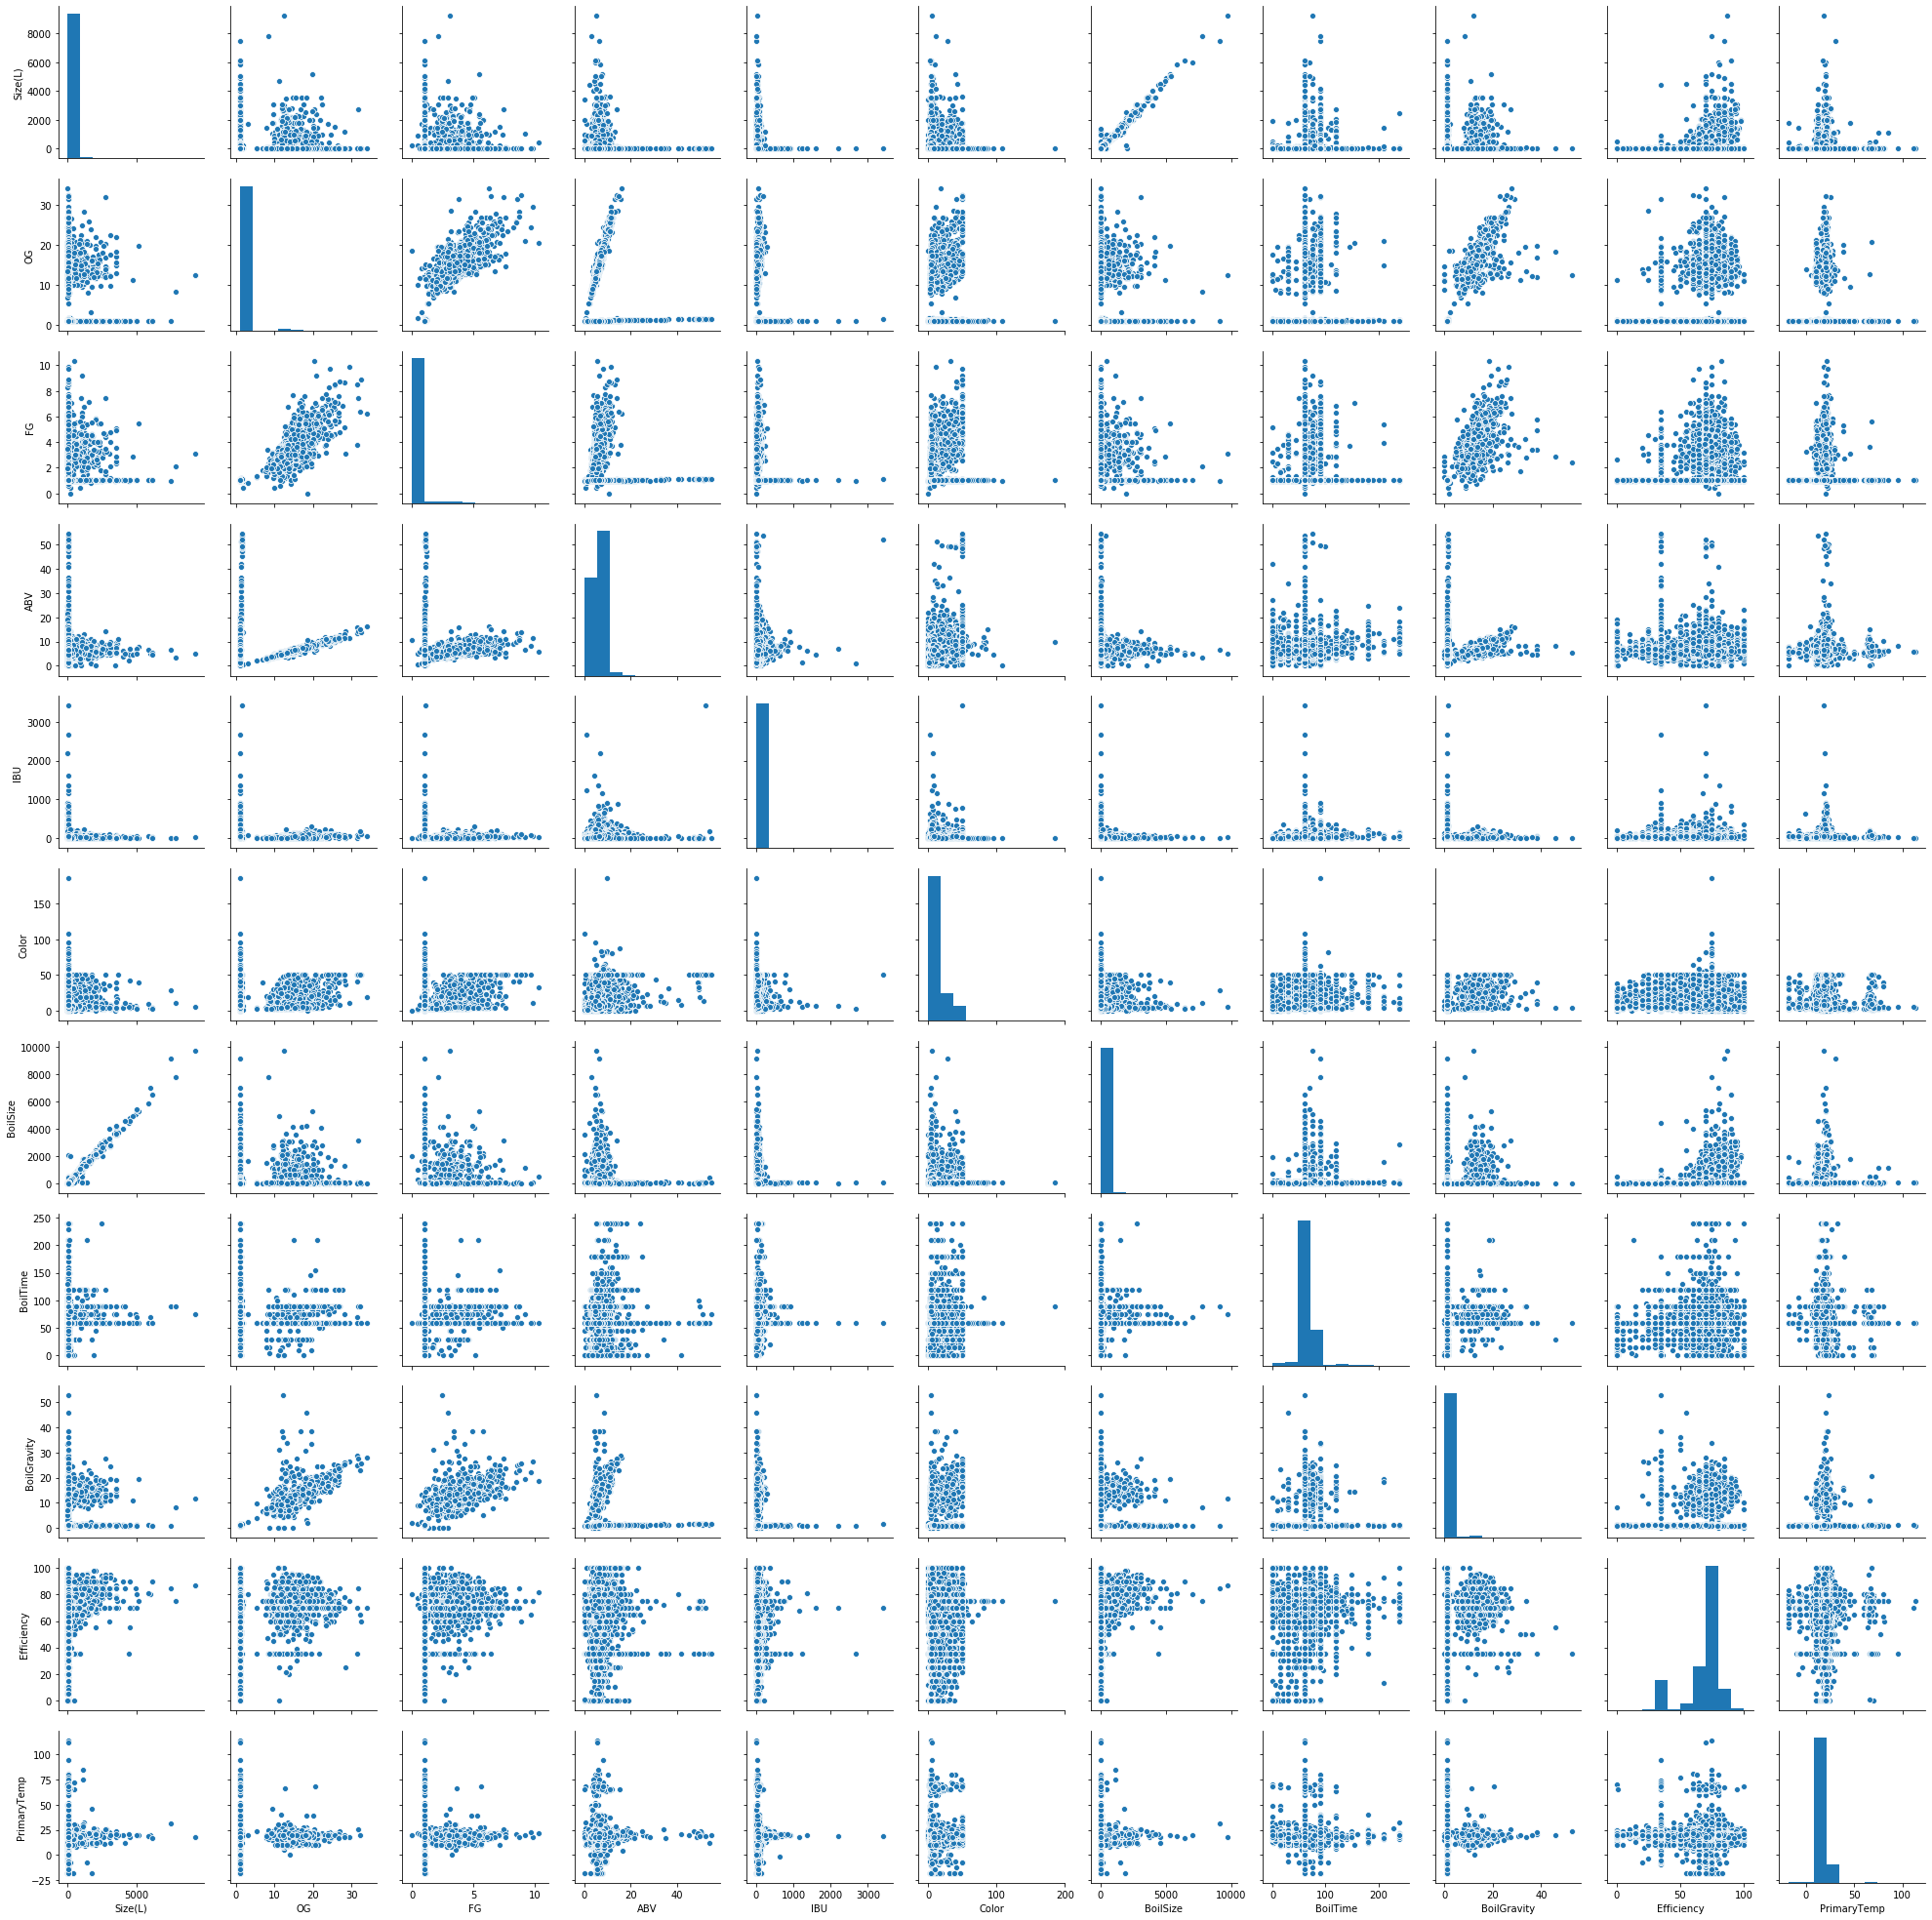

In [17]:
# plot pair plot for better intuitive view
sns.pairplot(data=data.loc[:, to_plot_cols])

In [18]:
# let's drop high-correlated features
num_features.remove('BoilSize')
num_features.remove('BoilGravity')

#### Categorical features

In [19]:
# url and name have the same information
data.loc[:, 'URL'] = data.loc[:,'URL'].apply(lambda x: x.split('/')[-1])
data[cat_features].head(10)

,Name,URL,SugarScale,BrewMethod,UserId
BeerID,,,,,
1,Vanilla Cream Ale,vanilla-cream-ale,Specific Gravity,All Grain,116
2,Southern Tier Pumking clone,southern-tier-pumking-clone,Specific Gravity,All Grain,955
3,Zombie Dust Clone - EXTRACT,zombie-dust-clone-extract,Specific Gravity,extract,NaN
4,Zombie Dust Clone - ALL GRAIN,zombie-dust-clone-all-grain,Specific Gravity,All Grain,NaN
5,Bakke Brygg Belgisk Blonde 50 l,bakke-brygg-belgisk-blonde-50-l,Specific Gravity,All Grain,18325
6,Sierra Nevada Pale Ale Clone,sierra-nevada-pale-ale-clone,Specific Gravity,All Grain,5889
7,Russian River Pliny the Elder (original),russian-river-pliny-the-elder-original-,Specific Gravity,All Grain,1051
8,Spotted Clown (New Glarus Spotted Cow clone),spotted-clown-new-glarus-spotted-cow-clone-,Specific Gravity,All Grain,116
9,Chocolate Vanilla Porter,chocolate-vanilla-porter,Specific Gravity,All Grain,116


In [20]:
print('there are {} different type of SugarScale \nthere are {} different type of BrewMethod'.format(
    data.SugarScale.nunique(), data.BrewMethod.nunique()))

there are 2 different type of SugarScale 
there are 4 different type of BrewMethod


In [21]:
# I will not use Name and userId, since name has the same information as in url but worse format.
cat_features.remove('Name')
cat_features.remove('UserId')

In [22]:
# let's extract information for last part of url
words = data.loc[:,'URL'].apply(lambda x: [w for w in x.split('-') if w])
words = pd.Series([y for x in words for y in x])
n_words = len(words)
nuni_words = words.nunique()
print('there are totally {} words in {} records, and {} unique words'.format(n_words, data.shape[0], nuni_words))

there are totally 212778 words in 73265 records, and 25979 unique words


In [23]:
# select high frequent words
word_frequence = pd.DataFrame(words.value_counts()/data.shape[0], columns = ['pct'])
high_frequency_words = word_frequence[word_frequence['pct'] >= 0.01].index.to_list()
useless_words = ['the', 'and', 'all', 'day', 'for', 'not', 'you']
use_words = [w for w in high_frequency_words if len(w)>2 and w not in useless_words]

### Feature Engineering

In [24]:
# to save the preprocess steps
prep_steps = {}
# generate features from the words and remove URL
use_words_features = use_words
for w in use_words_features:
    data.loc[:,w] = data['URL'].apply(lambda x: 1 if w in x else 0)
cat_features.remove('URL')

prep_steps['col_too_many_missing'] = col_too_many_missing
prep_steps['use_words_features'] = use_words_features
prep_steps['num_features'] = num_features
prep_steps['cat_features'] = cat_features

In [25]:
fs = num_features + use_words_features + cat_features
prep_data = data.loc[:, fs]
target = data.StyleID

In [26]:
cat_encoder = {}
# encode categrocial features
for _col in cat_features:
    encoder = LabelEncoder()
    prep_data.loc[:,_col] = encoder.fit_transform(prep_data[_col])
    cat_encoder[_col] = encoder
# impute missing values
missing_imputer = {}
for _col, s in {'PrimaryTemp':'mean'}.items():
    imputer = SimpleImputer(strategy=s)
    prep_data[_col] = imputer.fit_transform(prep_data[_col].values.reshape(-1,1))
    missing_imputer[_col] = imputer
prep_steps['cat_encoder'] = cat_encoder
prep_steps['missing_imputer'] = missing_imputer

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(prep_data, target, 
                                                    test_size=.2, stratify=target, random_state=1024)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
prep_steps['scaler'] = scaler

In [29]:
# let's try a basic RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(score))

Accuracy: 0.43765781751177235


In [34]:
# let's try a basic LGBMClassifier
lgb = LGBMClassifier(n_estimators=500, max_depth=7, learning_rate=0.02)
# Train valid split
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=22)
lgb.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], early_stopping_rounds=10, verbose=20)

Training until validation scores don't improve for 10 rounds
[20]	training's multi_logloss: 2.70957	valid_1's multi_logloss: 3.12126
[40]	training's multi_logloss: 2.26615	valid_1's multi_logloss: 2.80518
[60]	training's multi_logloss: 1.98943	valid_1's multi_logloss: 2.61418
[80]	training's multi_logloss: 1.79593	valid_1's multi_logloss: 2.49158
[100]	training's multi_logloss: 1.65156	valid_1's multi_logloss: 2.40991
[120]	training's multi_logloss: 1.53707	valid_1's multi_logloss: 2.34753
[140]	training's multi_logloss: 1.44405	valid_1's multi_logloss: 2.30297
[160]	training's multi_logloss: 1.36675	valid_1's multi_logloss: 2.26978
[180]	training's multi_logloss: 1.30134	valid_1's multi_logloss: 2.24527
[200]	training's multi_logloss: 1.24412	valid_1's multi_logloss: 2.22714
[220]	training's multi_logloss: 1.19506	valid_1's multi_logloss: 2.21333
[240]	training's multi_logloss: 1.15221	valid_1's multi_logloss: 2.20337
[260]	training's multi_logloss: 1.11388	valid_1's multi_logloss: 2.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
y_pred = lgb.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(score))

Accuracy: 0.4691189517504948


#### Thoughts on Performance
The performance of lightgbm is obviously better then RandomForest, even it talks long time to train. However, the accuracy is still not good enough, especially the rare classes.
#### How to improve
1. do more feature engineering, cleaning data, analyze the outliers, especially the `Size`, `OG`, `FG`.
2. better tuning the hyper paramters.
4. check the importance of features to prune the model
3. do ensemble to get a higher accuracy and more robust model.

### save preprocess and model

In [36]:
with open('prep_steps.pkl', 'wb') as f:
    pickle.dump(prep_steps, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('lgbmodel.pkl', 'wb') as f:
    pickle.dump(lgb, f, protocol=pickle.HIGHEST_PROTOCOL)